In [1]:
from keras.models import load_model

Using TensorFlow backend.


In [1]:
from keras.models import load_model
from keras.models import Model
from keras.regularizers import l2
from keras.layers import *
from keras.engine import Layer
from keras.applications.vgg16 import *
from keras.models import *
import keras.backend as K
import tensorflow as tf
def binary_crossentropy_with_logits(ground_truth, predictions):
    return K.mean(K.binary_crossentropy(ground_truth,
                                        predictions,
                                        from_logits=True),
                  axis=-1)
weight_decay = 0.
classes = 100
input_shape = (150,150,1)
img_input = Input(shape=input_shape)
image_size = input_shape[0:2]

# Block 1
x = Conv2D(64, (3, 3), padding='same',kernel_initializer='he_normal', name='block1_conv1', kernel_regularizer=l2(weight_decay))(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal',name='block1_conv2', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid',name='block1_pool')(x)
f1 = x

# Block 2
x = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal',name='block2_conv1', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3),  padding='same', kernel_initializer='he_normal',name='block2_conv2', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding="valid", name='block2_pool')(x)
f2 = x

# Block 3
x = Conv2D(256, (3, 3), padding='same',kernel_initializer='he_normal', name='block3_conv1', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal',name='block3_conv2', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3),  padding='same', kernel_initializer='he_normal',name='block3_conv3', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='block3_pool')(x)
f3 = x

# Block 4
x = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal',name='block4_conv1', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal',name='block4_conv2', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal',name='block4_conv3', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='block4_pool')(x)


# Convolutional layers transfered from fully-connected layers
x = Conv2D(4096, (5, 5), padding='same', kernel_initializer='he_normal',name='fc1', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Conv2D(2048, (1, 1), padding='same', kernel_initializer='he_normal',name='fc2', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
#classifying layer
x = Conv2D(classes, (1, 1), kernel_initializer='he_normal', padding='valid', strides=(1, 1), kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Activation('linear')(x)
#x = BilinearUpSampling2D(size=(16, 16))(x)

#x = Conv2D(classes, (1, 1),
#               padding='same', kernel_initializer='glorot_normal', kernel_regularizer=l2(weight_decay),
#               use_bias=False)(x)

x = Conv2DTranspose( classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False, kernel_regularizer=l2(weight_decay) )(x)

x2 = f3

x2 = ( Conv2D( classes ,  ( 1 , 1 ) ,kernel_initializer='he_normal',strides=(1, 1),kernel_regularizer=l2(weight_decay) ))(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('linear')(x2)

x = Cropping2D(cropping = ((0,2),(0,2)))(x)


x = Add()([x,x2])

x = Conv2DTranspose( classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False,kernel_regularizer=l2(weight_decay) )(x)

x2 = f2

x2 = ( Conv2D( classes ,  ( 1 , 1 ) ,kernel_initializer='he_normal',kernel_regularizer=l2(weight_decay) ))(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('linear')(x2)

#x , x2 = crop( x , x2 , img_input )
x = Cropping2D(cropping = ((0,1),(0,1)))(x)

x = Add()([x,x2])

x = Conv2DTranspose( classes , kernel_size=(8,8) ,  strides=(4,4) , use_bias=False )(x)

x = Cropping2D(cropping = ((0,2),(0,2)))(x)

x = ( Conv2D( 1 ,  ( 1 , 1 ) ,kernel_initializer='he_normal',kernel_regularizer=l2(weight_decay) ))(x)
x = BatchNormalization()(x)
#x2 = Activation('linear')(x2)


#x = BatchNormalization()(x)
#x = Activation('linear')(x)

row, col, channel = input_shape

# TODO(ahundt) this is modified for the sigmoid case! also use loss_shape
x = Reshape((-1,))(x)
x = (Activation('sigmoid'))(x)
#x = Flatten()(x)
model = Model(img_input, x)
model.summary()
model.load_weights('D:\\lizenan\\7th_model\\weights_epoch=18-val_loss=0.6981.hdf5')

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 1)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 150, 150, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 150, 150, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 150, 150, 64) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
block1_con

In [25]:
import cv2
import glob
import numpy
import matplotlib.pyplot as plt
import scipy.io as sio

def calc_precision_recall(ytrue, ypred):
    accuracy = len(np.where((ytrue==ypred))[0])/(ytrue.shape[0]*ytrue.shape[1])
    true_pos = len(np.where((ytrue==ypred)&(ytrue==1))[0])
    true_neg = len(np.where((ytrue==ypred)&(ytrue==0))[0])
    false_pos = len(np.where((ytrue!=ypred)&(ytrue==1))[0])
    false_neg = len(np.where((ytrue!=ypred)&(ytrue==0))[0])
    precision = float(true_pos)/(true_pos+false_pos)
    recall = float(true_pos)/(true_pos+false_neg)
    F1 = float(2*precision*recall)/(precision+recall)
    return accuracy, precision, recall, F1

test_pics = glob.glob('D:\lizenan\ground_crack_samples\CrackForest-dataset-master\CrackForest-dataset-master\image\\*')
gts = glob.glob('D:\lizenan\ground_crack_samples\CrackForest-dataset-master\CrackForest-dataset-master\groundTruth\*')
X = []
for pic in test_pics:
    input_X = cv2.imread(pic, cv2.IMREAD_GRAYSCALE)
    normalizedImg = np.zeros_like(input_X)
    input_X = input_X.astype(np.float32)
    input_X = cv2.normalize(input_X,  normalizedImg, -1, 1, cv2.NORM_MINMAX)
    input_X = cv2.resize(input_X,(150,150))
    input_X = input_X.reshape(150,150,1)
    X += [input_X]
    
y_true = []
for gt in gts:
    mat_contents = sio.loadmat(gt)
    seg_mask = mat_contents['groundTruth'][0][0][0]-1
    seg_mask[seg_mask>0] = 1
    seg_mask[seg_mask<=0] = 0
    seg_mask = cv2.resize(seg_mask,(150,150))
    seg_mask = seg_mask.reshape(150,150,1)
    y_true += [seg_mask]
a = np.array(y_true)
    
array_X = np.array(X).reshape(-1,150,150,1)
pred_y = model.predict(array_X)
y_true = np.array(y_true)
#print(y_true.shape)
pics = glob.glob('D:\lizenan\ground_crack_samples\CrackForest-dataset-master\CrackForest-dataset-master\image\*')
#pred_y2 = np.zeros_like(pred_y)
#pred_y_bn = cv2.normalize(pred_y,pred_y2,0,1,cv2.NORM_MINMAX)
#pred_y_bn_1 = pred_y_bn.copy()
pred_y_bn_2 = []
#print(pred_y_bn.min(),pred_y_bn.max())
for y_1 in pred_y:
    mean = y_1.mean()
    std = y_1.std()
    std_value = std*1.3
    y_1[y_1 < mean+std_value] = 0
    y_1[y_1 >= mean+std_value] = 1
    pred_y_bn_2 += [y_1]
pred_y_bn_2 = np.array(pred_y_bn_2)
y_true_1 = y_true.reshape(-1,22500)
accuracy, precision, recall, F1 = calc_precision_recall(y_true_1, pred_y_bn_2)
"""
for y,pic in zip(pred_y_bn,pics):
    a = cv2.imread(pic)
    #y1 = np.zeros_like(y)
    mean = y.mean()
    std = y.std()
    std_value = std*2.6
    y[y < mean+std_value] = 0
    y[y >= mean+std_value] = 1
    test = y.reshape(150,150)
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.subplot(1,2,2)
    plt.imshow(test)
    plt.show()
"""
print("accuracy: ",accuracy)
print("precision: ", precision)
print("recall: ", recall)
print("F1: ", F1)

accuracy:  0.9633811676082863
precision:  0.2126018431948711
recall:  0.20278684608647185
F1:  0.2075783879828186


In [5]:
pred_y = model.predict(array_X)

In [7]:
pred_y.max(),pred_y.min()

(1.0, 1.0738692e-11)

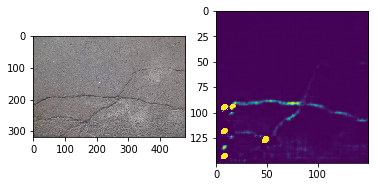

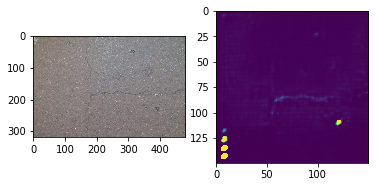

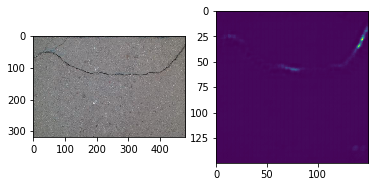

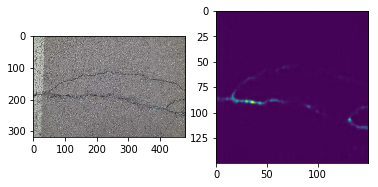

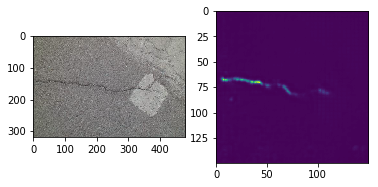

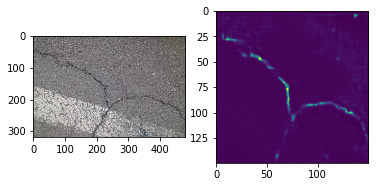

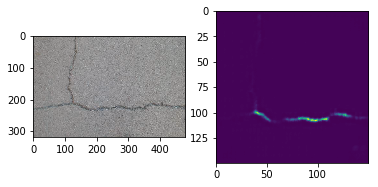

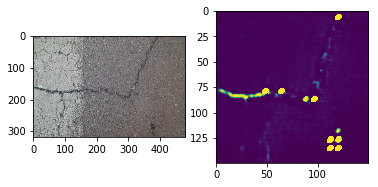

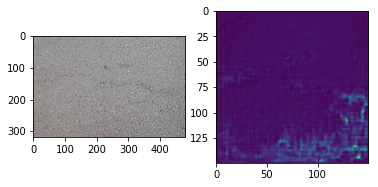

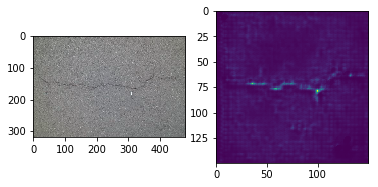

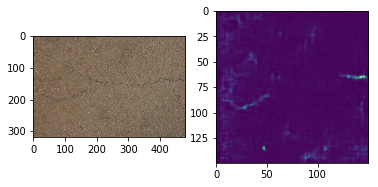

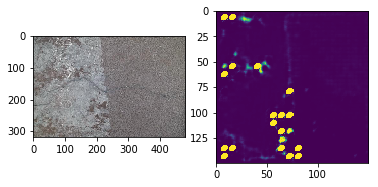

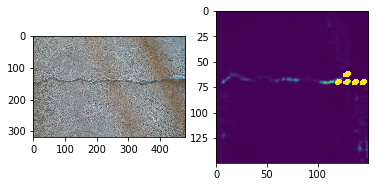

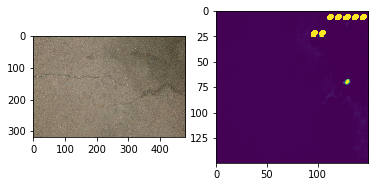

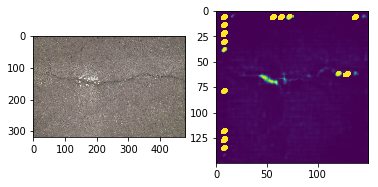

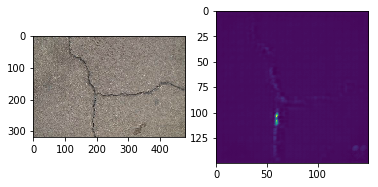

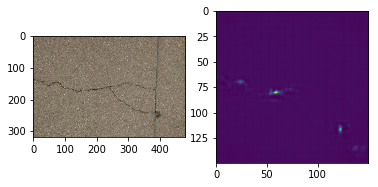

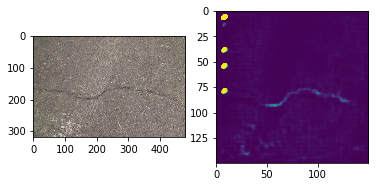

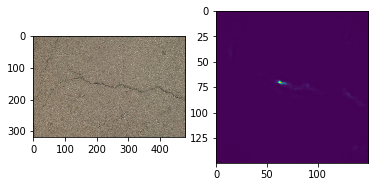

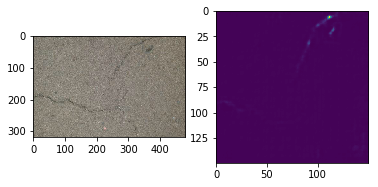

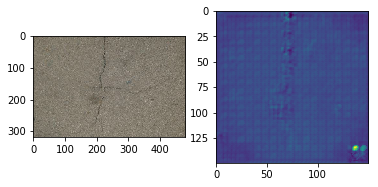

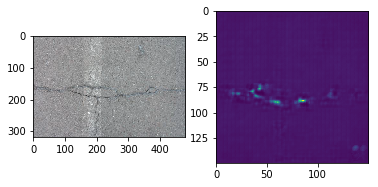

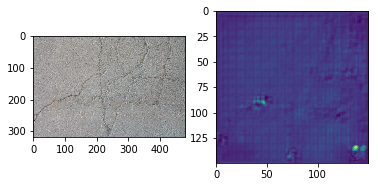

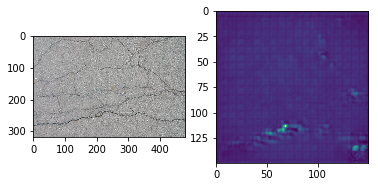

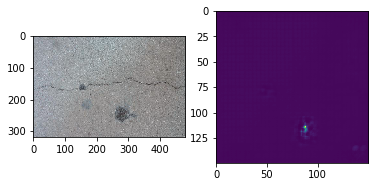

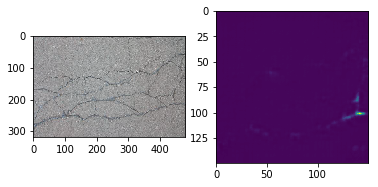

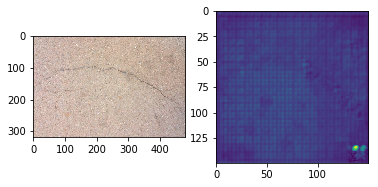

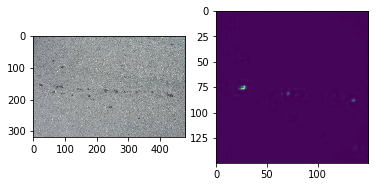

In [3]:
test_pics = glob.glob('D:\lizenan\ground_crack_samples\ground_crack_samples\\*')
X = []
for pic in test_pics:
    input_X = cv2.imread(pic, cv2.IMREAD_GRAYSCALE)
    normalizedImg = np.zeros_like(input_X)
    input_X = input_X.astype(np.float32)
    input_X = cv2.normalize(input_X,  normalizedImg, -1, 1, cv2.NORM_MINMAX)
    input_X = cv2.resize(input_X,(150,150))
    input_X = input_X.reshape(150,150,1)
    X += [input_X]
    
a = np.array(y_true)
    
array_X = np.array(X).reshape(-1,150,150,1)
pred_y = model.predict(array_X)
pred_y_bn = cv2.normalize(pred_y,pred_y2,0,1,cv2.NORM_MINMAX)
pics = glob.glob('D:\lizenan\ground_crack_samples\ground_crack_samples\*')


for y,pic in zip(pred_y_bn,pics):
    a = cv2.imread(pic)
    #y1 = np.zeros_like(y)
    #mean = y.mean()
    #std = y.std()
    #std_value = std*1.2
    #y[y < mean+std_value] = 0
    #y[y >= mean+std_value] = 1
    test = y.reshape(150,150)
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.subplot(1,2,2)
    plt.imshow(test)
    plt.show()

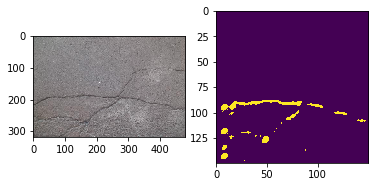

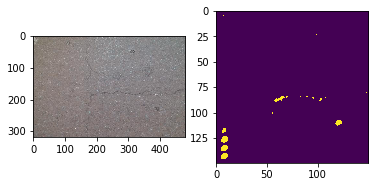

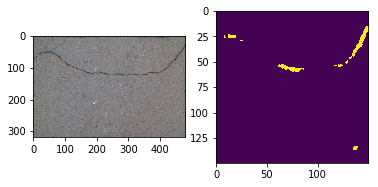

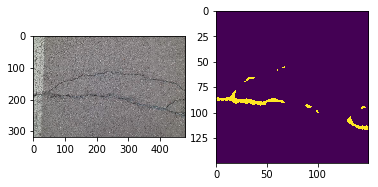

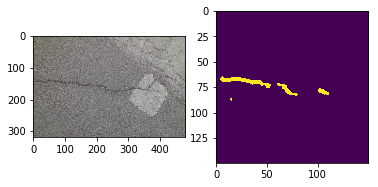

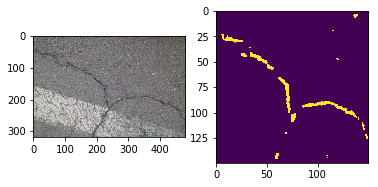

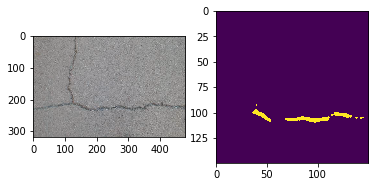

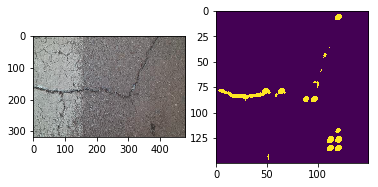

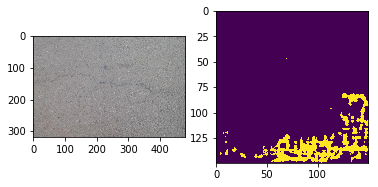

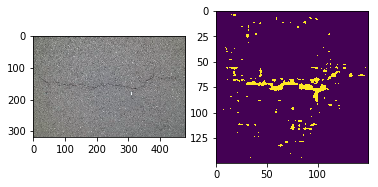

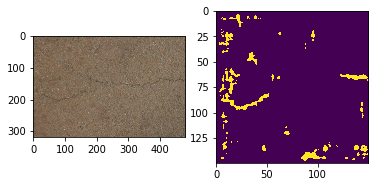

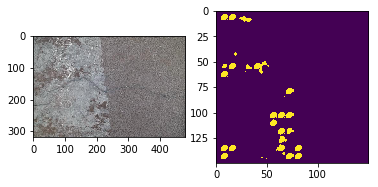

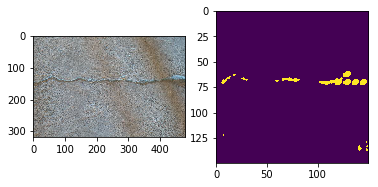

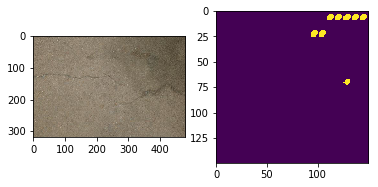

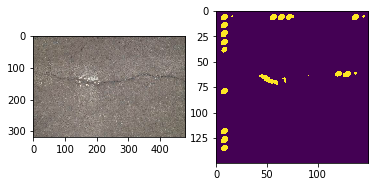

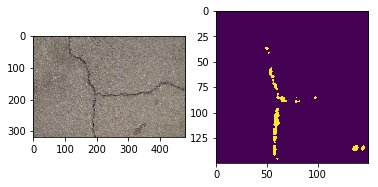

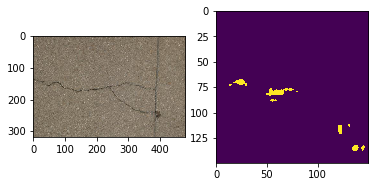

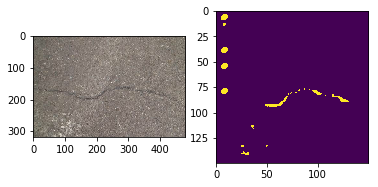

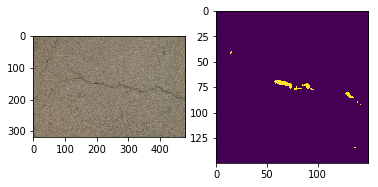

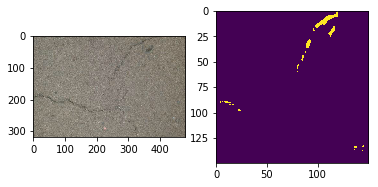

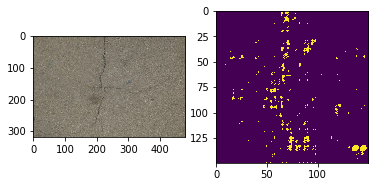

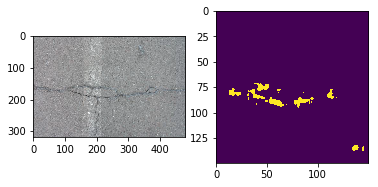

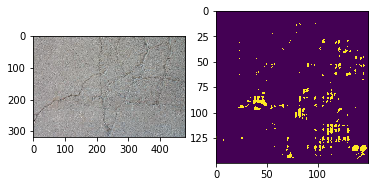

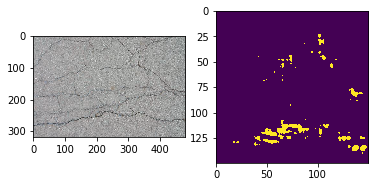

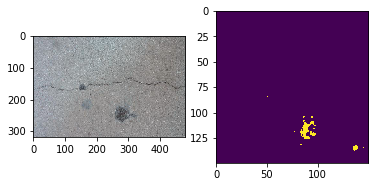

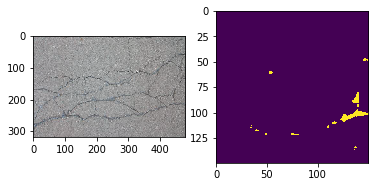

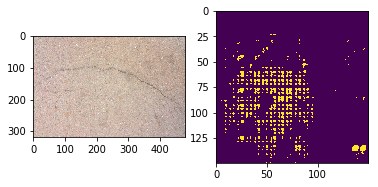

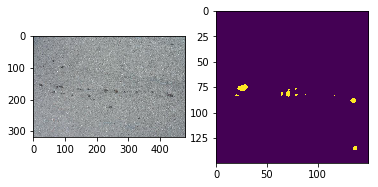

In [24]:

test_pics = glob.glob('D:\lizenan\ground_crack_samples\ground_crack_samples\\*')
X = []
for pic in test_pics:
    input_X = cv2.imread(pic, cv2.IMREAD_GRAYSCALE)
    normalizedImg = np.zeros_like(input_X)
    input_X = input_X.astype(np.float32)
    input_X = cv2.normalize(input_X,  normalizedImg, -1, 1, cv2.NORM_MINMAX)
    input_X = cv2.resize(input_X,(150,150))
    input_X = input_X.reshape(150,150,1)
    X += [input_X]
    
a = np.array(y_true)
    
array_X = np.array(X).reshape(-1,150,150,1)
pred_y = model.predict(array_X)
#y_true = np.array(y_true)
#print(y_true.shape)
pics = glob.glob('D:\lizenan\ground_crack_samples\ground_crack_samples\*')
#pred_y2 = np.zeros_like(pred_y)
#pred_y_bn = cv2.normalize(pred_y,pred_y2,0,1,cv2.NORM_MINMAX)
#pred_y_bn_1 = pred_y_bn.copy()
#pred_y_bn_2 = []


for y,pic in zip(pred_y,pics):
    a = cv2.imread(pic)
    #y1 = np.zeros_like(y)
    mean = y.mean()
    std = y.std()
    std_value = std*1.3
    y[y < mean+std_value] = 0
    y[y >= mean+std_value] = 1
    test = y.reshape(150,150)
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.subplot(1,2,2)
    plt.imshow(test)
    plt.show()